In [293]:
import pandas as pd
import numpy as np
import math
import csv
import random
from matplotlib import pyplot as plt

In [294]:
# Lengths for three links of the Robotic Arm
LINK1 = 14.0
LINK2 = 22.0
LINK3 = 6.0

# No of rows/samples to generate for the dataset
SAMPLES = 1500

# Number of digits after decimal point to keep in the data points
PRECISION = 3

# Number of epochs to iterate while training the model
NUMBER_OF_EPOCHS = 100

ARROW_LENGTH = 0.7

<h3><u>Generating Dataset</u></h3>

- Creating the Helper Functions:

In [295]:
#Angles are in Radian
def getXCoordinate(AngQ1, AngQ2, AngQ3):
    return LINK1*math.cos(AngQ1) + LINK2*math.cos(AngQ1 + AngQ2) + LINK3*math.cos(AngQ1 + AngQ2 + AngQ3)

def getYCoordinate(AngQ1, AngQ2, AngQ3):
    return LINK1*math.sin(AngQ1) + LINK2*math.sin(AngQ1 + AngQ2) + LINK3*math.sin(AngQ1 + AngQ2 + AngQ3)

def getTotalAngle(AngQ1, AngQ2, AngQ3):
    return math.degrees(AngQ1 + AngQ2 + AngQ3)

In [296]:
def generateDataset():
    with open('training_data.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = ["Q1", "Q2", "Q3", "XCoordEndEff", "YCoordEndEff", "TotalAngle"])
        writer.writeheader()

        for i in range (0,SAMPLES):
            #Randomly generating joint angles 
            q1= round(random.uniform(0, math.pi), PRECISION)
            q2= round(random.uniform(-math.pi, 0), PRECISION)
            q3= round(random.uniform(-math.pi/2, math.pi/2), PRECISION)

            writer.writerow({
                'Q1':q1,
                'Q2':q2,
                'Q3':q3,
                'XCoordEndEff':str(round(getXCoordinate(q1, q2, q3), PRECISION)),
                'YCoordEndEff':str(round(getYCoordinate(q1, q2, q3), PRECISION)),
                'TotalAngle':str(round(getTotalAngle(q1, q2, q3), PRECISION))
            })

- Generate Dataset:

In [297]:
#Uncomment the next line if to generate the dataset
#generateDataset()

In [298]:
dataset = pd.read_csv('training_data.csv')
dataset

,Q1,Q2,Q3,XCoordEndEff,YCoordEndEff,TotalAngle
0,1.412,-2.546,0.965,17.435,-7.120,-9.683
1,2.290,-0.272,0.055,-21.625,35.628,118.774
2,2.146,-0.396,-0.046,-12.334,39.342,97.632
3,0.726,-2.029,-1.435,10.773,-14.278,-156.876
4,1.086,-0.021,-0.018,20.185,36.828,59.989
...,...,...,...,...,...,...
1495,0.333,-0.335,1.432,36.073,10.473,81.933
1496,2.935,-0.870,0.228,-28.104,26.741,131.379
1497,2.973,-2.536,1.499,3.988,17.264,110.925
1498,2.405,-1.339,-0.987,6.250,29.134,4.526


In [299]:
coordX = dataset.iloc[:, [3]].values
coordY = dataset.iloc[:, [4]].values
thetaAng = dataset.iloc[:, [5]].values

In [300]:
#function to plot data points
def plotDataset():
    plt.figure(figsize=(9, 7))
    for i in range(len(coordX)):
        posx = coordX[i][0]
        posy = coordY[i][0]
        theta = thetaAng[i][0]
        plt.plot([posx, posx + ARROW_LENGTH * math.cos(math.radians(theta))], [posy, posy + ARROW_LENGTH * math.sin(math.radians(theta))],'k-')

    plt.scatter(coordX, coordY)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.title("Data set of " + str(SAMPLES) + " possible endeffector positions and orientations")
    dataset_fig = plt.gcf()
    plt.show()
    plt.draw()
    #dataset_fig.savefig('Plot of Data Points.png', dpi=100, bbox_inches='tight')

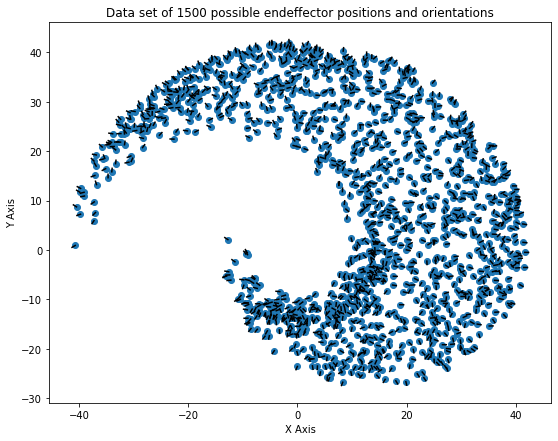

<Figure size 432x288 with 0 Axes>

In [301]:
plotDataset()

In [302]:
# Removing duplicated end effector positions
dups = dataset.duplicated(subset=["XCoordEndEff", "YCoordEndEff"])

# duplicated() method returns a series which contain false for all the unique values/rows
# Since the deduplicated dataset must contain only unique values we invert "dups" and select 
# all the rows which are true in "dups" 
dataset = dataset[~dups]
dataset

,Q1,Q2,Q3,XCoordEndEff,YCoordEndEff,TotalAngle
0,1.412,-2.546,0.965,17.435,-7.120,-9.683
1,2.290,-0.272,0.055,-21.625,35.628,118.774
2,2.146,-0.396,-0.046,-12.334,39.342,97.632
3,0.726,-2.029,-1.435,10.773,-14.278,-156.876
4,1.086,-0.021,-0.018,20.185,36.828,59.989
...,...,...,...,...,...,...
1495,0.333,-0.335,1.432,36.073,10.473,81.933
1496,2.935,-0.870,0.228,-28.104,26.741,131.379
1497,2.973,-2.536,1.499,3.988,17.264,110.925
1498,2.405,-1.339,-0.987,6.250,29.134,4.526


In [303]:
#The X and Y Coordinates and the end effector orientation is the input to the model
X = dataset.iloc[:, 3:].values

#The joint angles are the output from the model
y = dataset.iloc[:, :3].values

In [304]:
#Splitting dataset into training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=1, random_state=0)

In [305]:
# Feature Scaling
# Feature Scaling is done to ease the calculations involved while training the model
# also avoid any independent variable dominating another one

# Using MinMaxScaler to scale all the values to [-1, 1] range

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_test = scaler.fit_transform(X_test)

In [306]:
# 70% - Training, 15% - Validation, 15% - Testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=0)#0.25

In [307]:
import tensorflow as tf
from tensorflow import keras

In [308]:
#Function to build the neural network model
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(3, activation='linear', input_shape=(3, )))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(3, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.05), loss=tf.losses.mean_squared_error, metrics=['accuracy'])
    return model

In [309]:
#Building the model
model = build_model()

In [310]:
#Training the model
history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=NUMBER_OF_EPOCHS,
    verbose=2,
    validation_data=(X_val, y_val)
)

Train on 1045 samples, validate on 230 samples
Epoch 1/100
1045/1045 - 1s - loss: 0.7019 - acc: 0.8373 - val_loss: 0.3277 - val_acc: 0.9130
Epoch 2/100
1045/1045 - 0s - loss: 0.2413 - acc: 0.8890 - val_loss: 0.1511 - val_acc: 0.9565
Epoch 3/100
1045/1045 - 0s - loss: 0.1275 - acc: 0.9206 - val_loss: 0.0912 - val_acc: 0.9478
Epoch 4/100
1045/1045 - 0s - loss: 0.0806 - acc: 0.9397 - val_loss: 0.0587 - val_acc: 0.9522
Epoch 5/100
1045/1045 - 0s - loss: 0.0725 - acc: 0.9483 - val_loss: 0.0742 - val_acc: 0.9522
Epoch 6/100
1045/1045 - 0s - loss: 0.0654 - acc: 0.9407 - val_loss: 0.0742 - val_acc: 0.9348
Epoch 7/100
1045/1045 - 0s - loss: 0.0737 - acc: 0.9435 - val_loss: 0.0663 - val_acc: 0.9696
Epoch 8/100
1045/1045 - 0s - loss: 0.0488 - acc: 0.9464 - val_loss: 0.0364 - val_acc: 0.9652
Epoch 9/100
1045/1045 - 0s - loss: 0.0447 - acc: 0.9589 - val_loss: 0.0446 - val_acc: 0.9565
Epoch 10/100
1045/1045 - 0s - loss: 0.0548 - acc: 0.9483 - val_loss: 0.0503 - val_acc: 0.9652
Epoch 11/100
1045/1045

Epoch 88/100
1045/1045 - 0s - loss: 0.0312 - acc: 0.9598 - val_loss: 0.0322 - val_acc: 0.9609
Epoch 89/100
1045/1045 - 0s - loss: 0.0366 - acc: 0.9617 - val_loss: 0.0322 - val_acc: 0.9739
Epoch 90/100
1045/1045 - 0s - loss: 0.0393 - acc: 0.9560 - val_loss: 0.0351 - val_acc: 0.9783
Epoch 91/100
1045/1045 - 0s - loss: 0.0333 - acc: 0.9579 - val_loss: 0.0484 - val_acc: 0.9739
Epoch 92/100
1045/1045 - 0s - loss: 0.0353 - acc: 0.9656 - val_loss: 0.0395 - val_acc: 0.9739
Epoch 93/100
1045/1045 - 0s - loss: 0.0284 - acc: 0.9656 - val_loss: 0.0257 - val_acc: 0.9739
Epoch 94/100
1045/1045 - 0s - loss: 0.0293 - acc: 0.9713 - val_loss: 0.0415 - val_acc: 0.9565
Epoch 95/100
1045/1045 - 0s - loss: 0.0433 - acc: 0.9455 - val_loss: 0.0419 - val_acc: 0.9609
Epoch 96/100
1045/1045 - 0s - loss: 0.0362 - acc: 0.9550 - val_loss: 0.0311 - val_acc: 0.9739
Epoch 97/100
1045/1045 - 0s - loss: 0.0436 - acc: 0.9569 - val_loss: 0.0333 - val_acc: 0.9565
Epoch 98/100
1045/1045 - 0s - loss: 0.0609 - acc: 0.9522 - v

In [311]:
#Evaluating model on testing data 
print('Testing the model:\n')

test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTesting Loss = ', test_loss) 
print('Testing Accuracy = ', test_acc)

Testing the model:

225/225 [==============================] - 0s 1ms/sample - loss: 0.0774 - acc: 0.9111

Testing Loss =  0.07738380334029595
Testing Accuracy =  0.9111111


In [312]:
#print(history.history.keys())

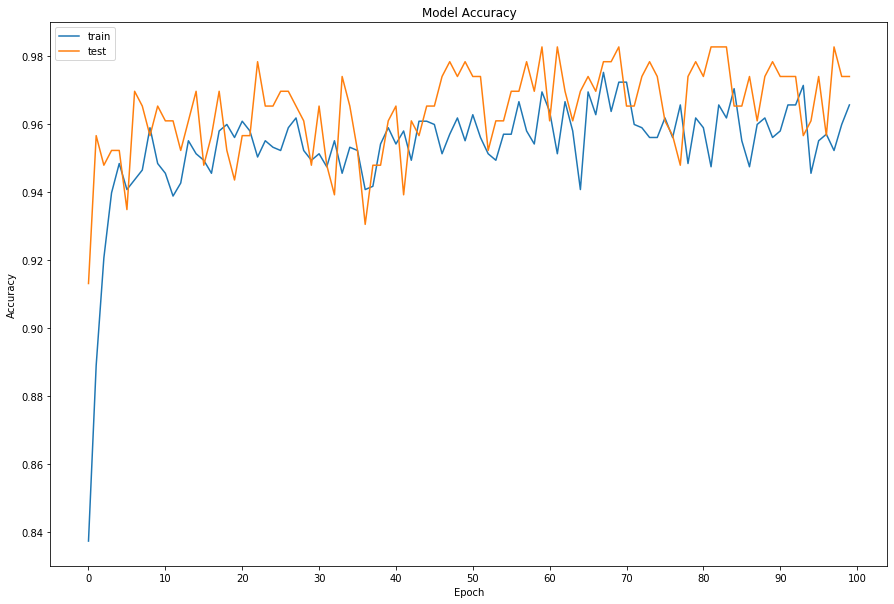

<Figure size 432x288 with 0 Axes>

In [313]:
# Summarize history for accuracy

plt.figure(figsize=(15, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(np.arange(0, NUMBER_OF_EPOCHS+1, 10))

model_acc_fig = plt.gcf()
plt.show()
plt.draw()
#model_acc_fig.savefig('Model Accuracy.png', dpi=100, bbox_inches='tight')

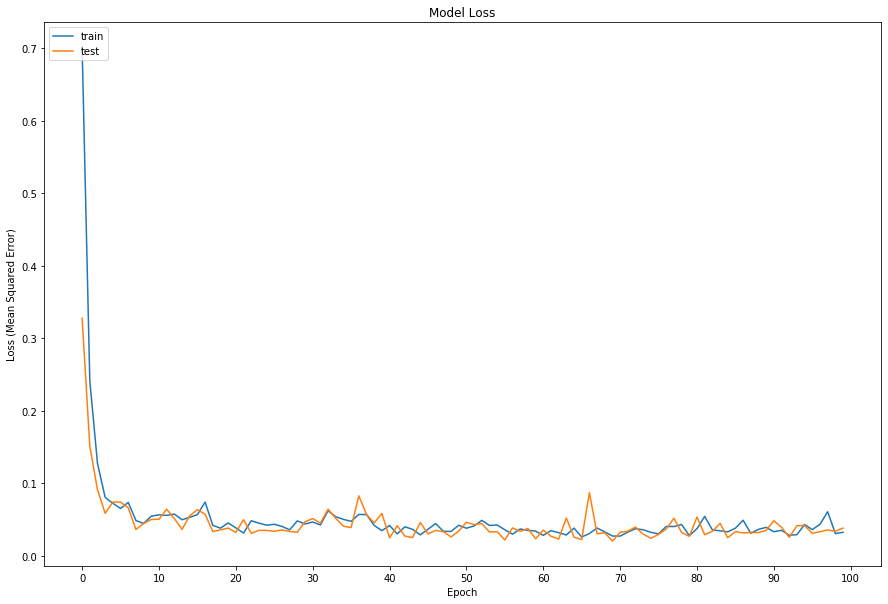

<Figure size 432x288 with 0 Axes>

In [314]:
# Summarize history for loss

plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(np.arange(0, NUMBER_OF_EPOCHS+1, 10))
model_loss_fig = plt.gcf()
plt.show()
plt.draw()
#model_loss_fig.savefig('Model Loss(MSE).png', dpi=100, bbox_inches='tight')

In [315]:
# Make Predictions
predictions = model.predict(X_test)

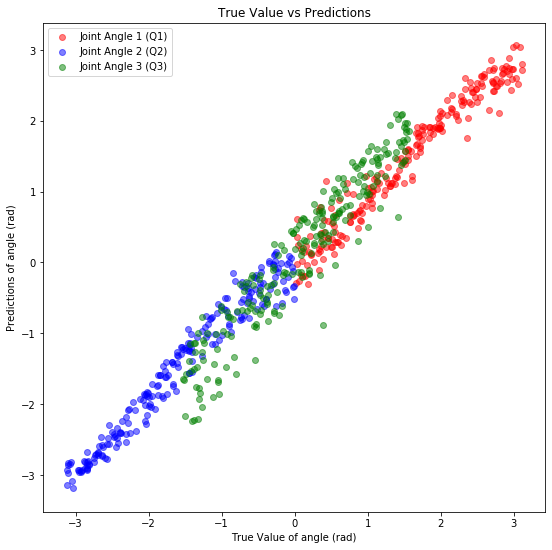

<Figure size 432x288 with 0 Axes>

In [316]:
# Scatter Plot for True Value vs Predictions of Joint Angles
plt.figure(figsize=(9, 9))
plt.scatter(y_test[:, 0], predictions[:, 0], label="Joint Angle 1 (Q1)", c="red",alpha=0.5)
plt.scatter(y_test[:, 1], predictions[:, 1], label="Joint Angle 2 (Q2)", c="blue",alpha=0.5)
plt.scatter(y_test[:, 2], predictions[:, 2], label="Joint Angle 3 (Q3)", c="green",alpha=0.5)

plt.title("True Value vs Predictions")
plt.xlabel('True Value of angle (rad)')
plt.ylabel('Predictions of angle (rad)')
plt.legend(loc='upper left')
actual_prediction_fig = plt.gcf()
plt.show()
plt.draw()
#actual_prediction_fig.savefig('True Value Vs Prediction.png', dpi=100, bbox_inches='tight')

In [317]:
# Get Predicted Coordinates

# We need to derive the predicted coordinates from the predicted joint angles.
predicted_coord = np.empty((len(predictions), 3))
for i in range(len(predictions)):
    ang = predictions[i, :]
    predicted_coord[i, 0] = getXCoordinate(ang[0], ang[1], ang[2])
    predicted_coord[i, 1] = getYCoordinate(ang[0], ang[1], ang[2])
    predicted_coord[i, 2] = getTotalAngle(ang[0], ang[1], ang[2])

In [318]:
# Getting the Actual Coordinates

# We need to inverse transform to get the coordinates back to the original range
# as they we transformed to range [-1, 1] during feature scaling.
actual_coord = scaler.inverse_transform(X_test)

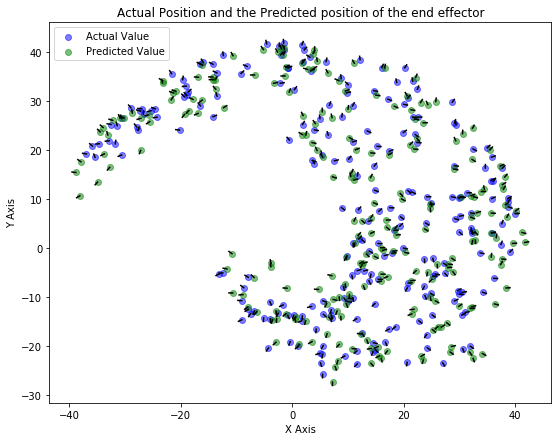

<Figure size 432x288 with 0 Axes>

In [319]:
# Plotting the Actual Position and the Predicted position of the end effector
plt.figure(figsize=(9, 7))
plt.scatter(actual_coord[:, 0], actual_coord[:, 1], label="Actual Value", c="blue",alpha=0.5)
plt.scatter(predicted_coord[:, 0], predicted_coord[:, 1], label="Predicted Value", c="green",alpha=0.5)

for i in range(len(actual_coord)):
        posx = actual_coord[i][0]
        posy = actual_coord[i][1]
        theta = actual_coord[i][2]
        plt.plot([posx, posx + ARROW_LENGTH * math.cos(math.radians(theta))], [posy, posy + ARROW_LENGTH * math.sin(math.radians(theta))],'k-')
        
        posx = predicted_coord[i][0]
        posy = predicted_coord[i][1]
        theta = predicted_coord[i][2]
        plt.plot([posx, posx + ARROW_LENGTH * math.cos(math.radians(theta))], [posy, posy + ARROW_LENGTH * math.sin(math.radians(theta))],'k-')

plt.legend(loc='upper left')
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Actual Position and the Predicted position of the end effector")
actual_predicted_fig = plt.gcf()
plt.show()
plt.draw()
#actual_predicted_fig.savefig('Plot of Actual Position and the Predicted position.png', dpi=100, bbox_inches='tight')